In [3]:
import time
import os
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models, datasets
from PIL import Image
from torch.autograd import Variable

### Train

In [19]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    
    start_time = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_losses = []
    val_losses = []
    train_acc = []
    val_acc = []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print ('-'*10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            num_correct = 0
            
                
            for data, labels in dataloaders[phase]:
                data = data.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    output = model(data)
                    loss = criterion(output, labels)
                    _, preds = torch.max(output.data, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                running_loss += loss.item()*data.size(0)
                num_correct += torch.sum(preds == labels.data)
                del data, labels, output, preds
                torch.cuda.empty_cache()
                #break
            epoch_loss =  running_loss / dataSizes[phase]
            epoch_acc = num_correct.double() / dataSizes[phase]
            
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_acc.append(epoch_acc)
                
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc)) 
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            #break    
        print()
        print('='*70) 
        print()
        #break
    time_elapsed = time.time() - start_time
    print('Training complete in {:.0f}mins {:.0f}secs'.format(time_elapsed // 60, time_elapsed % 60)) 
    print('Best accuracy {:.4f}'.format(best_acc * 100))
    
    model.load_state_dict(best_model_wts) #load it again to return it at the main function
    #model.save_state_dict('model_name.pt')
    
    return model, train_losses, train_acc, val_losses, val_acc   

In [17]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomRotation((90, 180)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5],[0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5],[0.5, 0.5, 0.5])
    ]),
    'test': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5],[0.5, 0.5, 0.5])
    ])
}

data_dir = '/media/eslam/7AE0CA83E0CA455B/Users/Eslam100/Documents/kaggledataset/fake_dataset/'
image_dataset = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                 for x in ['train', 'val', 'test']}

dataloaders = {x: DataLoader(image_dataset[x],
                             batch_size=batch_size,
                             shuffle=True,
                            num_workers=4)
              for x in ['train', 'val', 'test']}
dataSizes = {x: len(image_dataset[x]) for x in ['train', 'val', 'test']}
class_names = image_dataset['train'].classes

'''train_data = datasets.ImageFolder(root='/media/eslam/7AE0CA83E0CA455B/Users/Eslam100/Documents/kaggledataset/fake_dataset/train/')
val_data = datasets.ImageFolder(root='/media/eslam/7AE0CA83E0CA455B/Users/Eslam100/Documents/kaggledataset/fake_dataset/val/')
test_data = datasets.ImageFolder(root='/media/eslam/7AE0CA83E0CA455B/Users/Eslam100/Documents/kaggledataset/fake_dataset/test/')

batch_size = 16
lr = 0.001

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4)
'''

"train_data = datasets.ImageFolder(root='/media/eslam/7AE0CA83E0CA455B/Users/Eslam100/Documents/kaggledataset/fake_dataset/train/')\nval_data = datasets.ImageFolder(root='/media/eslam/7AE0CA83E0CA455B/Users/Eslam100/Documents/kaggledataset/fake_dataset/val/')\ntest_data = datasets.ImageFolder(root='/media/eslam/7AE0CA83E0CA455B/Users/Eslam100/Documents/kaggledataset/fake_dataset/test/')\n\nbatch_size = 16\nlr = 0.001\n\ntrain_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)\nval_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=4)\ntest_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4)\n"

### Test

In [20]:
def test_model(model, criterion, optimizer, scheduler, num_epochs= 25):
    model.eval()
    num_correct = 0
    test_losses = []
    running_loss = 0.0
    accuracy = 0
    for data, labels in dataloaders['test']:
        data = data.to(device)
        labels = labels.to(device)
        output = model(data)
        loss = criterion(output, labels)
        _,preds = torch.max(output.data, 1)
        running_loss += loss.data[0]*data.size(0)
        num_correct += torch.sum(preds == labels.data)
        true.extend(labels.data.cpu().numpy().tolist())
        pred.extend(preds.cpu().numpy().tolist())
        
    accuracy = num_correct/dataSizes['test']
    return accuracy

### Confusion matrix

In [13]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = 'd'
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
def plot_conf_matrix(y_test, y_pred, class_names):
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)
    print('CCR = {}'.format(np.trace(cnf_matrix) / len(y_test)))
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion Matrix')
    plt.show()

### Main

model is downloaded successfully
Epoch 0/29
----------
train Loss: 0.7152 Acc: 0.5580
val Loss: 0.6737 Acc: 0.6170


Epoch 1/29
----------
train Loss: 0.6568 Acc: 0.6167
val Loss: 0.7381 Acc: 0.5962


Epoch 2/29
----------
train Loss: 0.6678 Acc: 0.6276
val Loss: 0.6913 Acc: 0.6135


Epoch 3/29
----------
train Loss: 0.6350 Acc: 0.6338
val Loss: 0.6418 Acc: 0.6049


Epoch 4/29
----------
train Loss: 0.6169 Acc: 0.6587
val Loss: 0.6476 Acc: 0.6360


Epoch 5/29
----------
train Loss: 0.5794 Acc: 0.6783
val Loss: 0.5961 Acc: 0.6785


Epoch 6/29
----------
train Loss: 0.5820 Acc: 0.6876
val Loss: 0.5829 Acc: 0.6906


Epoch 7/29
----------
train Loss: 0.5558 Acc: 0.7053
val Loss: 0.5862 Acc: 0.6889


Epoch 8/29
----------
train Loss: 0.5683 Acc: 0.6982
val Loss: 0.6013 Acc: 0.6768


Epoch 9/29
----------
train Loss: 0.5653 Acc: 0.7072
val Loss: 0.5802 Acc: 0.6967


Epoch 10/29
----------
train Loss: 0.5627 Acc: 0.6960
val Loss: 0.5741 Acc: 0.6941


Epoch 11/29
----------
train Loss: 0.5625 

/home/eslam/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  del sys.path[0]


CCR = 0.6851025869759143
[[431 129]
 [224 337]]


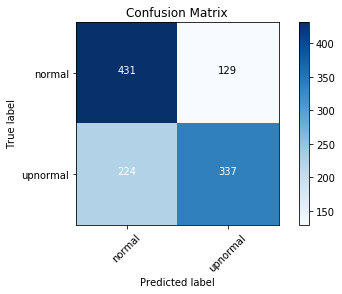

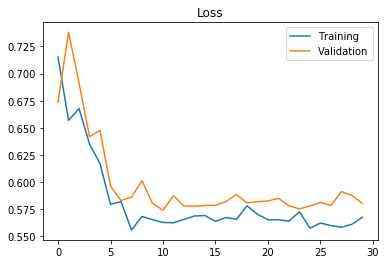

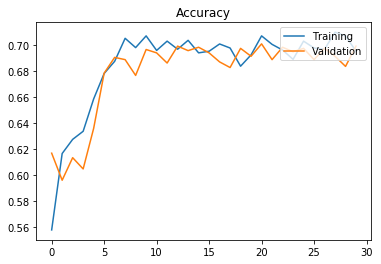

In [21]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
model = models.resnet18(pretrained=True)
print('model is downloaded successfully')
model.avgpool = nn.AdaptiveAvgPool2d(1)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
class_names = ['normal','upnormal']
true = []
pred = []
accuracy =0
num_epochs = 30

mymodel, train_losses, train_acc, val_losses, val_acc=train_model(model, criterion, optimizer, scheduler, num_epochs=num_epochs)
accuracy = test_model(mymodel, criterion, optimizer, scheduler, num_epochs = num_epochs)
plot_conf_matrix(true, pred, class_names)

### plotting ###
epochsRange = np.array(range(num_epochs))
plt.plot(epochsRange, train_losses, label='Training')
plt.plot(epochsRange, val_losses, label='Validation')
plt.title('Loss')
plt.legend(loc='upper right')
plt.show()

plt.plot(epochsRange, train_acc, label='Training')
plt.plot(epochsRange, val_acc, label='Validation')
plt.title('Accuracy')
plt.legend(loc='upper right')
plt.show()

In [28]:
accuracy.item()

0